In [0]:
try:
  import tflearn
except ImportError:
  !pip3 install -q tflearn
  import tflearn

In [0]:
import numpy as np
from glob import glob
import os
from google.colab import drive
import matplotlib.pyplot as plt
import os, sys
import glob
from scipy.misc import imread, imresize, imshow
from tflearn.layers.core import input_data, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, global_avg_pool
from tflearn.layers.estimator import regression

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('drive/My Drive/DeepLearningFall2018/card-pics')

In [5]:
os.getcwd()

'/content/drive/My Drive/DeepLearningFall2018/card-pics'

In [6]:
os.listdir()

['diamonds', 'clubs', 'hearts', 'spades']

In [0]:
def img_reader(dir, imsz, file_ex=None, sort=False):
    main_dir = os.getcwd()
    
    if file_ex is None:
        file_ex = '*'
    else:
        file_ex = '*' + file_ex

    folders = os.listdir(dir)
    os.chdir(dir)
    num_ims=sum([len(files) for r, d, files in os.walk(os.getcwd())])
    imgs = np.zeros([num_ims, imsz[0], imsz[1], 3])
    labels = np.zeros([num_ims, 1])

    for subdir, folder in enumerate(folders):
        os.chdir(dir + '/' + folder)
        files = glob.glob(file_ex)
        if sort:
            files.sort()
        for i, file in enumerate(files):
            if os.path.isfile(file):
                img = imread(file)
                img = imresize(img, [imsz[0], imsz[1]])
                imgs[i, ...] = img
                labels[i, 0] = subdir

    os.chdir(main_dir)            
    return imgs, labels

In [8]:
X, Y = img_reader(os.getcwd(), [150, 150])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [0]:
from tflearn.data_utils import to_categorical
Y = to_categorical(Y, 4)

In [10]:
print(X.shape)

(1760, 150, 150, 3)


In [0]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
def install_tensorboard_dep():
  '''Installs tensorboard to be used in colab.'''
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')

In [0]:
def start_tensorboard():
  '''Starts tensorboard on colaboratory.'''
  LOG_DIR = '/tmp/tflearn_logs'  # where the log files will go
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [14]:
response = input("Do you want to train a network? >")
if response in ['Y', 'y', 'Yes', 'yes', 'yep']:
  print("Yeah aight") # this used to be all I did in Python, text adventures and stuff
  Train = True
else:
  Train = False

Do you want to train a network? >yep
Yeah aight


In [15]:
print(Train)

True


In [16]:
print(X.shape, Y.shape)

(1760, 150, 150, 3) (1760, 4)


In [0]:
emb = tf.Variable(X[::10, ...], name='input_card_images')

In [0]:
tf.reset_default_graph()

In [19]:
# input layer
input_layer = input_data([None, 150, 150, 3])
# convolution 1
conv1 = conv_2d(input_layer, 64, 7, strides=2, activation='relu', name='c1')
# max pooling layer 1
pool1 = max_pool_2d(conv1, 3, 2)
# convolution 2
conv2 = conv_2d(pool1, 128, 3, strides=2, activation='relu', name='c2')
# max pooling layer 
pool2 = max_pool_2d(conv2, 3, 2)
# convolution 3
conv3 = conv_2d(pool2, 256, 3, strides=2, activation='relu', name='c3')
# global average pool
gap = global_avg_pool(conv3)
# output layer
output_layer = fully_connected(gap, 4, activation='softmax')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [20]:
# optimization
network = regression(output_layer, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.001)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# create network with established hyperparameters
# and send it to tensorboard for visualization
model = tflearn.DNN(network, tensorboard_verbose=3)
tensorboard_name = 'playingcards_CNN'

In [23]:
# start running tensorboard
install_tensorboard_dep()
start_tensorboard()

http://f6b27fbb.ngrok.io


In [0]:
tf.reset_default_graph()

In [25]:
# training scenario 1
if Train == True:
  model.fit(X,
            Y,
            batch_size=50,
            n_epoch=50,
            validation_set=0.2,
            shuffle=True,
            show_metric=True,
            run_id='cardsCNN5')
  model.save('models/training1')

Training Step: 1449  | total loss: 16.70356 | time: 16.962s
| Adam | epoch: 050 | loss: 16.70356 - acc: 0.6613 -- iter: 1400/1408
Training Step: 1450  | total loss: 16.64547 | time: 18.639s
| Adam | epoch: 050 | loss: 16.64547 - acc: 0.6952 | val_loss: 13.49894 - val_acc: 0.2386 -- iter: 1408/1408
--
INFO:tensorflow:/content/drive/My Drive/DeepLearningFall2018/card-pics/models/training1 is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'


In [0]:
num_classes = 4
conf_mat = np.zeros([num_classes, num_classes])

In [0]:
for val_sample in range(X.shape[0]):
  x = X[val_sample, ...]
  y = Y[val_sample, ...]
  
  y = np.argmax(y)
  
  output = model.predict(x[None, ...])
  
  output = np.argmax(output)
  
  conf_mat[y, output] += 1

In [28]:
conf_mat

array([[ 506., 1254.,    0.,    0.],
       [   0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.]])

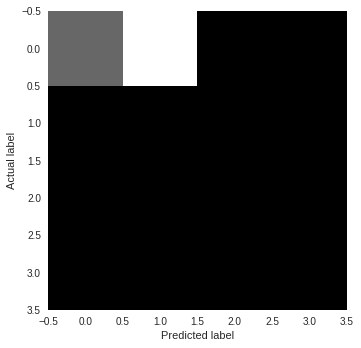

In [34]:
plt.imshow(conf_mat, cmap='gray')
plt.grid(False)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
# training scenario 2
if Train == True:
  model.fit(X,
            Y,
            batch_size=50,
            n_epoch=50,
            validation_set=0.2,
            shuffle=True,
            show_metric=True,
            snapshot_step=100,
            run_id='cardsCNN3')
  model.save('models/training2')

Training Step: 708  | total loss: 14.48812 | time: 18.256s
| Adam | epoch: 025 | loss: 14.48812 - acc: 0.1517 -- iter: 1400/1408


KeyboardInterrupt: ignored

In [0]:
# last training scenario
if Train == True:
  model.fit(X,
            Y,
            batch_size=50,
            n_epoch=50,
            validation_set=0.1,
            shuffle=True,
            show_metric=True,
            snapshot_step=100,
            run_id='cardsCNN3')
  model.save('models/training3')

Training Step: 477  | total loss: 15.13346 | time: 18.165s
| Adam | epoch: 015 | loss: 15.13346 - acc: 0.0000 -- iter: 1450/1584


KeyboardInterrupt: ignored